https://github.com/teddylee777/langchain-kr/blob/main/12-RAG/03-Conversation-With-History.ipynb

# 성공한 듯

In [2]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

In [3]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("240722")

LangSmith 추적을 시작합니다.
[프로젝트명]
240722


In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.transform import TransformChain
from operator import itemgetter

In [5]:
## 컬렉션 생성/연결하기
import chromadb
client = chromadb.PersistentClient('chroma/')
client.list_collections()

[Collection(name=49_files_openai_3072),
 Collection(name=12_files_openai_3072),
 Collection(name=csv_files_openai_3072)]

In [6]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

In [7]:
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """
            너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
            이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
            Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
            주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
            답변에는 Document라는 단어를 사용하지 말아줘.
            
            답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
            만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
            이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                      
            만약 Document를 기반으로 답변을 하지 않는 경우, 너가 생각한대로 답변을 하괴, 답변의 끝에 작성하는 출처에는 '참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.' 라고 표기해줘
    

            #Previous Chat History:
            {chat_history}

            #Question: 
            {question} 

            #Context: 
            {context} 

            #Answer:"""
            )


llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

chain = (
    {
        "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)

# 세션 기록을 저장할 딕셔너리
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    # print(f"[대화 세션ID]: {session_ids}")
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 대화를 기록하는 RAG 체인 생성
rag_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,  # 세션 기록을 가져오는 함수
    input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
    history_messages_key="chat_history",  # 기록 메시지의 키
)

In [ ]:
# # 세션 기록을 저장할 딕셔너리
# store = {}

# # 세션 ID를 기반으로 세션 기록을 가져오는 함수
# def get_session_history(session_ids):
#     # print(f"[대화 세션ID]: {session_ids}")
#     if session_ids not in store:  # 세션 ID가 store에 없는 경우
#         # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
#         store[session_ids] = ChatMessageHistory()
#     return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# # 대화를 기록하는 RAG 체인 생성
# rag_with_history = RunnableWithMessageHistory(
#     chain,
#     get_session_history,  # 세션 기록을 가져오는 함수
#     input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
#     history_messages_key="chat_history",  # 기록 메시지의 키
# )

In [10]:
def rag_with_history(query):
    rag_with_history.invoke(
    # 질문 입력
    {"question": query},
    # 세션 ID 기준으로 대화를 기록합니다.
    config={"configurable": {"session_id": "rag123"}})

In [11]:
rag_with_history('도로명주소법 1조의 내용은?')

AttributeError: 'function' object has no attribute 'invoke'

In [8]:
rag_with_history.invoke(
    # 질문 입력
    {"question": "도로명주소법 1조의 내용은?"},
    # 세션 ID 기준으로 대화를 기록합니다.
    config={"configurable": {"session_id": "rag123"}},
)

'도로명주소법 제1조는 다음과 같습니다:\n\n"이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다."\n\n출처: 도로명주소법'

In [ ]:
rag_with_history.invoke(
    # 질문 입력
    {"question": "도로명주소법 1조의 내용은?"},
    # 세션 ID 기준으로 대화를 기록합니다.
    config={"configurable": {"session_id": "rag123"}},
)

In [ ]:
rag_with_history.invoke(
    # 질문 입력
    {"question": "2조의 내용은?"},
    # 세션 ID 기준으로 대화를 기록합니다.
    config={"configurable": {"session_id": "rag123"}},
)

# 이건 뭐지

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# 단계 1: 문서 로드(Load Documents)
loader = PDFPlumberLoader("data/pdf/도로명주소법(법률)(제17574호)(20210609).pdf")
docs = loader.load()

# 단계 2: 문서 분할(Split Documents)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)

# 단계 3: 임베딩(Embedding) 생성
embeddings = OpenAIEmbeddings()

# 단계 4: DB 생성(Create DB) 및 저장
# 벡터스토어를 생성합니다.
vectorstore = Chroma(client=client, collection_name="49_files_openai_3072", embedding_function=embedding)
# chromadb_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 1})
# vectorstore = FAISS.from_documents(documents=split_documents, embedding=embeddings)

# 단계 5: 검색기(Retriever) 생성
# 문서에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

# 단계 6: 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

#Previous Chat History:
{chat_history}

#Question: 
{question} 

#Context: 
{context} 

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# 세션 기록을 저장할 딕셔너리
store = {}


# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    print(f"[대화 세션ID]: {session_ids}")
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 대화를 기록하는 RAG 체인 생성
rag_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,  # 세션 기록을 가져오는 함수
    input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
    history_messages_key="chat_history",  # 기록 메시지의 키
)

In [ ]:
rag_with_history.invoke(
    # 질문 입력
    {"question": "도로명주소법 1조의 내용은?"},
    # 세션 ID 기준으로 대화를 기록합니다.
    config={"configurable": {"session_id": "rag123"}},
)

# Langgraph 결합

In [16]:
import os
import time
import uuid
from dotenv import load_dotenv
## langsmith
from langsmith import Client
from langchain_teddynote import logging
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
from langchain_community.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_message_histories import ChatMessageHistory
## LangGraph
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
## Streamlit
import streamlit as st
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
from streamlit_feedback import streamlit_feedback
from langchain_core.tracers import LangChainTracer
from langchain_core.tracers.run_collector import RunCollectorCallbackHandler
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.tracers.langchain import wait_for_all_tracers

In [17]:
# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
langchain_endpoint = "https://api.smith.langchain.com"

session_id = ''

if openai_api_key:
    st.session_state["openai_api_key"] = openai_api_key
if langchain_api_key:
    st.session_state["langchain_api_key"] = langchain_api_key

In [18]:
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

In [19]:
##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)

In [20]:
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

In [21]:
##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

In [22]:
##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """
            너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
            이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
            Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
            주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
            답변에는 Document라는 단어를 사용하지 말아줘.
            
            답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
            만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
            이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                      
            만약 Document를 기반으로 답변을 하지 않는 경우, 너가 생각한대로 답변을 하괴, 답변의 끝에 작성하는 출처에는 '참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.' 라고 표기해줘
    

            #Previous Chat History:
            {chat_history}

            #Question: 
            {question} 

            #Context: 
            {context} 

            #Answer:"""
            )


llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

chain = (
    {
        "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)

# 세션 기록을 저장할 딕셔너리
if "store" not in st.session_state:
    st.session_state["store"] = {}
    
# store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
# def get_session_history(session_ids):
#     # print(f"[대화 세션ID]: {session_ids}")
#     if session_ids not in store:  # 세션 ID가 store에 없는 경우
#         # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
#         store[session_ids] = ChatMessageHistory()
#     return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환

def get_session_history(session_ids):
    if session_ids not in st.session_state["store"]:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        st.session_state["store"][session_ids] = ChatMessageHistory()
    return st.session_state["store"][session_ids]  # 해당 세션 ID에 대한 세션 기록 반환

# 대화를 기록하는 RAG 체인 생성
rag_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,  # 세션 기록을 가져오는 함수
    input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
    history_messages_key="chat_history",  # 기록 메시지의 키
)


def llm_answer(state: GraphState) -> GraphState:
    response = rag_with_history.invoke({'question': state["question"]}, config={"configurable": {"session_id": "rag123"}})
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )

In [23]:
##############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": "llm_answer",  # 관련성이 있으면 종료합니다.
        "관련성 X": "llm_answer",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "llm_answer",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

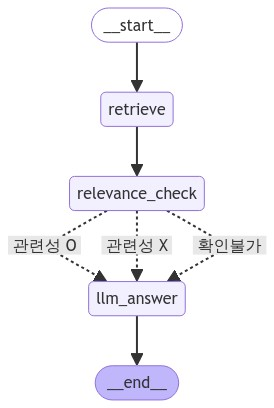

In [24]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [25]:
print("Current session state keys:", st.session_state.keys())
if "store" not in st.session_state:
    print("Initializing store in session state.")
    st.session_state["store"] = {}

Current session state keys: KeysView(<streamlit.runtime.state.session_state_proxy.SessionStateProxy object at 0x11b3cde50>)


In [26]:
inputs = GraphState(question='도로명주소법 1조의 내용은?')
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
output = app.invoke(inputs, config=config)
output

{'question': '도로명주소법 1조의 내용은?',
 'context': [(Document(metadata={'source': 'data/final/도로명주소법.txt'}, page_content='도로명주소법\n[시행 2021. 6. 9.] [법률 제17574호, 2020. 12. 8., 전부개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다.'),
   0.8625850081443787),
  (Document(metadata={'source': 'data/final/도로명주소법시행령.txt'}, page_content='도로명주소법 시행령\n[시행 2024. 5. 28.] [대통령령 제34533호, 2024. 5. 28., 타법개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 영은 「도로명주소법」에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다.\n\n제2조(정의) 이 영에서 사용하는 용어의 뜻은 다음과 같다.\n1. “예비도로명”이란 도로명을 새로 부여하려거나 기존의 도로명을 변경하려는 경우에 임시로 정하는 도로명을 말한다.\n2. “유사도로명”이란 특정 도로명을 다른 도로명의 일부로 사용하는 경우 특정 도로명과 다른 도로명 모두를 말한다.\n3. “동일도로명”이란 도로구간이 서로 연결되어 있으면서 그 이름이 같은 도로명을 말한다.\n4. “종속구간”이란 다음 각 목의 어느 하나에 해당하는 구간으로서 별도로 도로구간으로 설정하지 않고 그 구간에 접해 있는 주된 도로구간에 포함시킨 구간을 말한다.\n가. 막다른 구간\n나. 2개의 도로를 연결하는 구간'),
   0.8684205412864685)],
 'answer': 

In [28]:
output['answer']

'도로명주소법 제1조는 다음과 같습니다:\n\n"이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다."\n\n출처: 도로명주소법, 도로명주소법 시행령, 주소용어최종정리_1123 - 업데이트_231123'

In [ ]:
inputs = GraphState(question='2조의 내용은?')
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
output = app.invoke(inputs, config=config)
output

In [ ]:
inputs = GraphState(question='도로명주소법 2조의 내용은?')
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
output = app.invoke(inputs, config=config)
output

In [ ]:
inputs = GraphState(question='도로명주소법 2조에는 총 몇 개의 용어가 정의되어 있어?')
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
output = app.invoke(inputs, config=config)
output

In [ ]:
inputs = GraphState(question='여전히 틀렸어')
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
output = app.invoke(inputs, config=config)
output

In [ ]:
# import os
# import time
# import uuid
# from dotenv import load_dotenv
# ## langsmith
# from langsmith import Client
# from langchain_teddynote import logging
# ## OpenAI
# from langchain_openai import ChatOpenAI
# from langchain.schema import ChatMessage
# from langchain.embeddings.openai import OpenAIEmbeddings
# from langchain.schema import AIMessage, HumanMessage, SystemMessage
# from langchain_core.messages import HumanMessage, SystemMessage
# from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
# ## ChromaDB
# import chromadb
# from langchain.vectorstores import Chroma
# from langchain_community.vectorstores import Chroma
# ## History
# from operator import itemgetter
# from langchain_core.prompts import PromptTemplate
# from langchain_community.chat_message_histories import ChatMessageHistory
# ## LangGraph
# from langchain_core.output_parsers import StrOutputParser
# from typing import TypedDict
# from langgraph.graph import END, StateGraph
# from langgraph.checkpoint.memory import MemorySaver
# from langchain_core.runnables import RunnableConfig
# ## Streamlit
# import streamlit as st
# from langchain_community.chat_message_histories import StreamlitChatMessageHistory
# from streamlit_feedback import streamlit_feedback
# from langchain_core.tracers import LangChainTracer
# from langchain_core.tracers.run_collector import RunCollectorCallbackHandler
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_core.runnables.history import RunnableWithMessageHistory
# from langchain.callbacks.base import BaseCallbackHandler
# from langchain.callbacks.tracers.langchain import wait_for_all_tracers

# # .env 파일 활성화 & API KEY 설정
# load_dotenv()
# openai_api_key = os.getenv('OPENAI_API_KEY')
# langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
# langchain_endpoint = "https://api.smith.langchain.com"

# session_id = ''

# if openai_api_key:
#     st.session_state["openai_api_key"] = openai_api_key
# if langchain_api_key:
#     st.session_state["langchain_api_key"] = langchain_api_key
    
# ##############################################################################################################
# ################################################Retriever#####################################################
# ##############################################################################################################
# class MultiCollectionRetriever:
#     def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
#         self.collections = [
#             Chroma(client=client, collection_name=name, embedding_function=embedding_function)
#             for name in collection_names
#         ]
#         self.search_kwargs = search_kwargs

#     def retrieve(self, query):
#         results = []
#         for collection in self.collections:
#             # 각 컬렉션에서 유사도 검색 수행
#             documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
#             results.extend(documents_with_scores)
        
#         # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
#         results.sort(key=lambda x: x[1], reverse=False)

#         documents = [(doc, score) for doc, score in results]
#         return documents

# # 사용 예시
# client = chromadb.PersistentClient('chroma/')
# collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
# embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
# multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

# ##############################################################################################################
# ################################################GraphState####################################################
# ##############################################################################################################
# # GraphState 상태를 저장하는 용도
# class GraphState(TypedDict):
#     question: str  # 질문
#     context: str  # 문서의 검색 결과
#     answer: str  # llm이 생성한 답변
#     relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    
# ##############################################################################################################
# ################################################vector Retriever##############################################
# ##############################################################################################################
# def retrieve_document(state: GraphState) -> GraphState:
#     # Question 에 대한 문서 검색을 retriever 로 수행합니다.
#     retrieved_docs = multi_retriever.retrieve(state["question"])
#     # 검색된 문서를 context 키에 저장합니다.
#     return GraphState(context=retrieved_docs[:2])

# ##############################################################################################################
# ################################################Groundness Checker ###########################################
# ##############################################################################################################
# chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

# def relevance_message(context, question):
#     messages = [
#         SystemMessage(content="""
#             너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

#             'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
#             'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
#             'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
#             너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
#         """),
#         HumanMessage(content=f"""
#             [Document]
#             {context}

#             [Query]
#             {question}
#         """),
#     ]
#     return messages

# def relevance_check(state: GraphState) -> GraphState:
#     messages = relevance_message(state["context"], state["question"])
#     response = chat.invoke(messages)
#     return GraphState(
#         relevance=response.content,
#         context=state["context"],
#         answer=state["answer"],
#         question=state["question"],
#     )

# def is_relevant(state: GraphState) -> GraphState:
#     if state["relevance"] == "grounded":
#         return "관련성 O"
#     elif state["relevance"] == "notGrounded":
#         return "관련성 X"
#     elif state["relevance"] == "notSure":
#         return "확인불가"
    
# ##############################################################################################################
# ################################################LLM Answer Maker##############################################
# ##############################################################################################################

# # 프롬프트를 생성합니다.
# prompt = PromptTemplate.from_template(
#     """
#             너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
#             이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
#             Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
#             주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
#             답변에는 Document라는 단어를 사용하지 말아줘.
            
#             답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
#             만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
#             이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                      
#             만약 Document를 기반으로 답변을 하지 않는 경우, 너가 생각한대로 답변을 하괴, 답변의 끝에 작성하는 출처에는 '참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.' 라고 표기해줘
    

#             #Previous Chat History:
#             {chat_history}

#             #Question: 
#             {question} 

#             #Context: 
#             {context} 

#             #Answer:"""
#             )


# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# chain = (
#     {
#         "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
#         "question": itemgetter("question"),
#         "chat_history": itemgetter("chat_history"),
#     }
#     | prompt
#     | llm
#     | StrOutputParser()
# )

# # 세션 기록을 저장할 딕셔너리
# if "store" not in st.session_state:
#     st.session_state["store"] = {}

# # 세션 ID를 기반으로 세션 기록을 가져오는 함수
# def get_session_history(session_ids):
#     # print(f"[대화 세션ID]: {session_ids}")
#     if session_ids not in store:  # 세션 ID가 store에 없는 경우
#         # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
#         store[session_ids] = ChatMessageHistory()
#     return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# # 대화를 기록하는 RAG 체인 생성
# rag_with_history = RunnableWithMessageHistory(
#     chain,
#     get_session_history,  # 세션 기록을 가져오는 함수
#     input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
#     history_messages_key="chat_history",  # 기록 메시지의 키
# )


# def llm_answer(state: GraphState) -> GraphState:
#     response = rag_with_history.invoke({'question': state["question"]}, config={"configurable": {"session_id": "rag123"}})
#     return GraphState(
#         answer=response,
#         context=state["context"],
#         question=state["question"],
#     )
    
# ##############################################################################################################
# ################################################Setting Graph Relations#######################################
# ##############################################################################################################

# workflow = StateGraph(GraphState)

# # 노드들을 정의합니다.
# workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
# workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
# workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

# workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변

# # 조건부 엣지를 추가합니다.
# workflow.add_conditional_edges(
#     "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     is_relevant,
#     {
#         "관련성 O": "llm_answer",  # 관련성이 있으면 종료합니다.
#         "관련성 X": "llm_answer",  # 관련성이 없으면 다시 답변을 생성합니다.
#         "확인불가": "llm_answer",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
#     },
# )

# workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# # 시작점을 설정합니다.
# workflow.set_entry_point("retrieve")

# # 기록을 위한 메모리 저장소를 설정합니다.
# memory = MemorySaver()

# # 그래프를 컴파일합니다.
# app = workflow.compile(checkpointer=memory)

# ##############################################################################################################
# ##############################################################################################################
# ##############################################################################################################
# if "query" not in st.session_state:
#     st.session_state.query = None

# reset_history = st.sidebar.button("대화내용 초기화", type="primary")

# # 메모리
# msgs = StreamlitChatMessageHistory(key="langchain_messages")


# if reset_history:
#   msgs.clear()
#   st.session_state["last_run"] = None
#   st.session_state.messages = []
#   st.session_state.query = None
#   st.session_state.store = {}

# if "messages" not in st.session_state:
#   st.session_state["messages"] = []

# # 세션 상태에 저장된 모든 메시지 출력
# for msg in st.session_state.messages:
#     st.chat_message(msg.role).write(msg.content)

# # 유저의 입력을 받아서 대화를 진행합니다.
# if user_input := st.chat_input():
#     if st.session_state.query is None:
#         st.session_state.query = user_input
#     st.session_state.messages.append(ChatMessage(role="user", content=user_input))
#     st.chat_message("user").write(user_input)

#     # RunnableConfig와 GraphState를 사용하여 답변 생성
#     config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
#     inputs = GraphState(question=user_input)

#     # 답변 생성 및 출력
#     with st.chat_message("assistant"):
#         with st.spinner("Thinking..."):
#             output = app.invoke(inputs, config=config)
#             assistant_response = output["answer"]
#             st.markdown(assistant_response)
#         st.session_state.messages.append(ChatMessage(role="assistant", content=assistant_response))

In [1]:
import os
from dotenv import load_dotenv
## langsmith
from langsmith import Client
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
## gradio
import gradio as gr

# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')

store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환

##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        results.sort(key=lambda x: x[1], reverse=False)
        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large')  # 올바른 모델 이름 사용
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
class GraphState(TypedDict):
    question: str  # 질문
    context: list  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)

##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    retrieved_docs = multi_retriever.retrieve(state["question"])
    return GraphState(question=state["question"], context=retrieved_docs[:2], answer="", relevance="")

##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label 'notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

prompt = PromptTemplate.from_template(
    """
            너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
            이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
            Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
            주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
            답변에는 Document라는 단어를 사용하지 말아줘.
            
            답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
            만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
            이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                      
            만약 Document를 기반으로 답변을 하지 않는 경우, 너가 생각한대로 답변을 하괴, 답변의 끝에 작성하는 출처에는 '참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.' 라고 표기해줘
    
            #Previous Chat History:
            {chat_history}

            #Question: 
            {question} 

            #Context: 
            {context} 

            #Answer:"""
)

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

chain = (
    {
        "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)

rag_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,  # 세션 기록을 가져오는 함수
    input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
    history_messages_key="chat_history",  # 기록 메시지의 키
)

def llm_answer(state: GraphState) -> GraphState:
    response = rag_with_history.invoke({'question': state["question"]}, config={"configurable": {"session_id": "rag123"}})
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
        relevance=state["relevance"]
    )

##############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변

workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": "llm_answer",  # 관련성이 있으면 종료합니다.
        "관련성 X": "llm_answer",  
        "확인불가": "llm_answer",  
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료

workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

############################################################################################################
############# Gradio 인터페이스 생성 #############################################################################
############################################################################################################

def chat(query, history=None):
    print(query)
    if history is None:
        history = []
    
    inputs = GraphState(question=query)
    config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
    output = app.invoke(inputs, config=config)
    print(output['answer'])
    return output['answer']



/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [1]:
import os
from dotenv import load_dotenv
## langsmith
from langsmith import Client
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
## gradio
import gradio as gr

# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
langchain_endpoint = "https://api.smith.langchain.com"

session_id = ''

store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환
    
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"
    
##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """
            너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
            이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
            Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
            주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
            답변에는 Document라는 단어를 사용하지 말아줘.
            
            답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
            만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
            이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                      
            만약 Document를 기반으로 답변을 하지 않는 경우, 너가 생각한대로 답변을 하괴, 답변의 끝에 작성하는 출처에는 '참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.' 라고 표기해줘
    

            #Previous Chat History:
            {chat_history}

            #Question: 
            {question} 

            #Context: 
            {context} 

            #Answer:"""
            )


llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

chain = (
    {
        "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)




# 대화를 기록하는 RAG 체인 생성
rag_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,  # 세션 기록을 가져오는 함수
    input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
    history_messages_key="chat_history",  # 기록 메시지의 키
)


def llm_answer(state: GraphState) -> GraphState:
    response = rag_with_history.invoke({'question': state["question"]}, config={"configurable": {"session_id": "rag123"}})
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )
    
##############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": "llm_answer",  # 관련성이 있으면 종료합니다.
        "관련성 X": "llm_answer",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "llm_answer",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
langgraph_bot = workflow.compile(checkpointer=memory)

# def chat(query):
#     inputs = GraphState(question=query)
#     config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})
#     output_generator = langgraph_bot.stream(inputs, config=config)
#     output = list(output_generator)
#     return output[-1]['llm_answer']['answer']

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [2]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

def stream_responses(question):
    config = RunnableConfig(
        recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        # for output in langgraph_bot.stream(inputs, config=config):
        #     # 출력된 결과에서 키와 값을 순회합니다.
        #     for key, value in output.items():
        #         # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
        #         pprint.pprint(f"Output from node '{key}':")
        #         pprint.pprint("---")
        #         # 출력 값을 예쁘게 출력합니다.
        #         pprint.pprint(value, indent=2, width=80, depth=None)
        #     # 각 출력 사이에 구분선을 추가합니다.
        #     pprint.pprint("\n---\n")
        output_generator = langgraph_bot.stream(inputs, config=config)
        output = list(output_generator)
    except GraphRecursionError as e:
        pprint.pprint(f"Recursion limit reached: {e}")
    return output[-1]['llm_answer']['answer']

# 사용 예제
stream_responses("생성형 AI 가우스를 만든 회사의 2023년도 매출액은 얼마인가요?")

'생성형 AI 가우스를 만든 회사의 2023년도 매출액에 대한 정보는 제공된 자료에 포함되어 있지 않습니다. \n\n참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.'

In [2]:
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=5, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="hi"
)

output_generator = langgraph_bot.stream(inputs, config=config)
output = list(output_generator)

In [62]:
output[-1]['llm_answer']['answer']

'안녕하세요! 어떻게 도와드릴까요?\n\n참고한 문서에는 해당 질문에 답변할 수 있는 내용이 없습니다.'

In [52]:
len(output)

3

## 함수 invoke 테스트

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-cbe13672-a389-48c1-9e71-9ae5e1ebb1a5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17})

In [4]:
def llm_chat(query):
    llm = ChatOpenAI()
    return llm.invoke(query)

llm_chat('hi')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d9032132-b4d8-4c20-b38d-cceadd8f4ade-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17})

In [3]:
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI()

# template 정의. {country}는 변수로, 이후에 값이 들어갈 자리를 의미
template = "{country}의 수도는 어디인가요?"

# from_template 메소드를 이용하여 PromptTemplate 객체 생성
prompt = PromptTemplate.from_template(template)
chain = prompt | llm

def llm_chat_template(query):
    return chain.invoke(query).content

llm_chat_template('대한민국')

'대한민국의 수도는 서울입니다.'